# Imports

In [1]:
import random
import time
import enum
import math
from collections import namedtuple
from multiprocessing.pool import Pool
from typing import Tuple, NamedTuple, List
from tqdm import tqdm

import numpy as np
import pandas as pd
import pylab as plt
import networkx as nx
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
import plotnine as p9
import scipy
import sys

sys.path.insert(0, "./lib")

from lib.networkgen import Network, NetworkType
from lib.model import ModelWrapper
from lib.modelgen import Model, SIRModel, SEIZModel, SEIZplusModel, SEIZMModel, MoneyAgent
ModelType = Model.ModelType

# Initial Parameters

In [42]:
 # Simulation parameters

params = {
    ModelType.SIR: {
        'model': SIRModel.Params(
            initial_infected=0.01,
            initial_disagree=0.01,
            p_opinion_change=0.03
        ),
        'agent': None,
        'state_labels': [("Unsure", 'cornflowerblue'), ("Disagree","green"), ("Believe",'red')]
    },
    ModelType.SEIZ: {
        'model': SEIZModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=0.03,
            prob_S_with_Z=0.03,
            prob_E_to_I=0.01
        ),
        'agent': None,
        'state_labels': [("Susceptible", 'cornflowerblue'), ("Exposed", "orange"), ("Skeptic","green"), ("Infected",'red')]
    },
    ModelType.SEIZplus: {
        'model': SEIZplusModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=0.03,
            prob_S_with_Z=0.03,
            neighbor_threshold=0.7
        ),
        'agent': None,
        'state_labels': [("Susceptible", 'cornflowerblue'), ("Exposed", "orange"), ("Skeptic","green"), ("Infected",'red')]
    },
    ModelType.SEIZM: {
        'model': SEIZMModel.Params(
            initial_infected = 0.01,
            initial_skeptics = 0.01,
            prob_S_with_I = 0.03,
            prob_S_with_Z = 0.03,
            certainty_threshold = 0.3,
            influence_threshold = 0.3,
            money_theshold = 0.3,
            influence_increase = 0.1,
            certainty_increase = 0.1,
            neighbor_threshold = 0.8
        ),
        'agent': MoneyAgent.Params(
            0.5,    # certainty
            0.5,    # influence
            0,      # money
            0.5     # sentiment
        ),
        'state_labels': [("Susceptible", 'cornflowerblue'), ("Exposed", "orange"), ("Skeptic","green"), ("Infected",'red')]
    }
}

network_params = {
    # Parameters are chosen such that all networks have similar density
    NetworkType.CAVEMAN: (5, 20),  # (l, k)
    NetworkType.WINDMILL: (5, 11),  # (n, k)
    NetworkType.SMALLWORLD: (100, 10, 0.05),
    NetworkType.GAUSSIAN_RANDOM_PARTITION: (100, 5, 10, 0.3, 0.1),  # (n, s, v, p_in, p_out)
    NetworkType.BARABASI_ALBERT: (100, 12, 50, 0.95)  # (n, m1, m2, p)
}

# Helper functions

In [3]:
# Model Generation

def create_model(dynamics, network):
    # dynamics = ModelType.SEIZplus
    # network = NetworkType.CAVEMAN

    model = ModelWrapper(
        model_type=dynamics,
        model_params=params[dynamics]['model'],
        agent_params=params[dynamics]['agent'],
        network_type=network,
        network_params=network_params[network]
    )

    return model

In [39]:
# convenience function to collect plotable data
def sum_agents(model, state_labels):
    agent_data = model.data_collector().get_agent_vars_dataframe()

    # sum up different opinions each (time) step
    agents_summed = pd.pivot_table(agent_data, index = 'Step', columns = 'State', aggfunc = np.size, fill_value = 0)
   
    #check whether exposed state never occured and add if not
    if not 1 in agents_summed.columns:
        agents_summed[1] = 0
    
    #reorder state columns
    agents_summed = agents_summed.reindex(sorted(agents_summed.columns), axis = 1)
        
    # relabel
    labels = [l[0] for l in state_labels]
       
    agents_summed.columns = labels
    return agents_summed


# run multiple replicates of the model:
def run_replicates(new_model, state_labels, n_replicates, n_steps):

    for i in tqdm(range(n_replicates), desc="Run"):

        #(re-)initiate model
        model = new_model()

        #run model
        model.run(n_steps)

        #data collection
        if i == 0:
            replicates = sum_agents(model, state_labels)
        else:
            replicates = pd.concat([replicates, sum_agents(model, state_labels)])

    #calculate means and standard error of the mean
    replicates = pd.pivot_table(replicates, index = ["Step"], aggfunc = [np.mean, scipy.stats.sem])

    return replicates

# plot trajectories with errors:
def plot_trajectories(data, colors_ggplot):
    # data wrangling for ggplot
    data = data.stack(level=1).reset_index(1).rename(columns={"level_1": "Population"}).sort_values("Population")
    data.reset_index(inplace=True)
    data = data.rename(columns = {'index':'Step'})

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'Step', y = "mean", fill = "Population", group = "Population", color = "Population"))
    + p9.geom_line()
    + p9.geom_ribbon(p9.aes(x = 'Step', ymin = data["mean"] - data["sem"], ymax = data["mean"] + data["sem"]), outline_type = "none", alpha = 0.25, show_legend = False)
    + p9.ylab("Population size")
    + p9.xlab("Step")
    + p9.scale_color_manual(values = colors_ggplot)
    + p9.scale_fill_manual(values = colors_ggplot)
    + p9.coord_cartesian(ylim = {0, max(data['mean'])}, xlim = {0, max(data["Step"])})
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot

In [5]:
def run_trajectories(dynamics, network, n_steps = 100, n_replicates = 10):
    df = run_replicates(
        lambda: create_model(dynamics, network),
        state_labels=params[dynamics]['state_labels'],
        n_replicates = n_replicates,
        n_steps = n_steps)

    plot_trajectories(df, {label: color for label, color in params[dynamics]['state_labels']})

In [12]:
# Phase Diagram

dynamics, network = ModelType.SEIZ, NetworkType.CAVEMAN

def phase_diagram(n_steps = 100, n_replicates = 10, para_1 = "test", para_2 = "test2", para_1_min = 0, para_2_min = 0, 
                para_2_max = 1, para_1_max = 1, para_1_by = 0.1, para_2_by = 0.1):

    for i in np.arange(para_1_min, para_1_max+para_1_by, para_1_by):

        for k in np.arange(para_2_min, para_2_max+para_2_by, para_2_by):

            #change parameters:
            params[dynamics]['model'] = SEIZModel.Params(
            initial_infected = 0.01,
            initial_skeptics = 0.01,
            prob_S_with_I = i,
            prob_S_with_Z = k,
            prob_E_to_I = 0.001
            )          
            
            #run model n_replicate times:
            for n in range(n_replicates):
                
                #(re-)initialize model
                model = create_model(dynamics, network)
                
                #run model:
                model.run(n_steps)
                
                #data collection of replicates             
                if n == 0:
                    replicates = sum_agents(model, params[dynamics]['state_labels']).tail(1)
                else:
                    replicates = pd.concat([replicates, sum_agents(model, params[dynamics]['state_labels']).tail(1)], ignore_index=True)
            
            #calculate mean of the fraction of believers at endstate over the replicates
            replicates["fraction"] = replicates["Infected"]/replicates.sum(axis = 1)
            mean_fraction = replicates["fraction"].mean()
               
            # Create DataFrame             
            df = pd.DataFrame([[mean_fraction, i, k]], columns=('mean_fraction', para_1, para_2))
            
         
            #data collection
            if i == para_1_min and k == para_2_min:
                phase_data = df
            else:
                phase_data = pd.concat([phase_data, df])

    return(phase_data)
        

In [13]:
def plot_phase_diagram(data, x_label, y_label):

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'test', y = "test2", fill = "mean_fraction"))
    + p9.geom_tile()
    + p9.scale_fill_continuous(name = "Fraction believers", limits = {0,1})
    + p9.ylab(x_label)
    + p9.xlab(y_label)
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot


In [ ]:
#phase plot test

#run model data - this takes a while!
test = phase_diagram() 

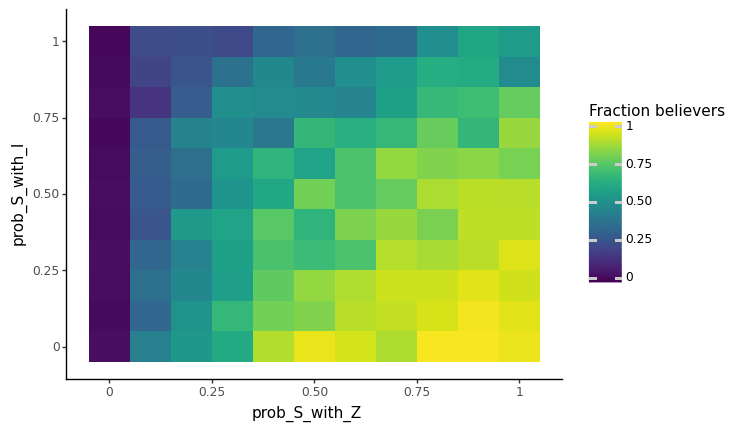

In [15]:
#plot it:
test_phase = plot_phase_diagram(test, str("prob_S_with_I"), str("prob_S_with_Z"))


### NOTE: running phase diagrams essentially changes "global" model parameters - hence reset those before running the simulations below.

# Simulation Runs

## SIR Model

### SIR with CAVEMEN Network

Run: 100%|██████████| 100/100 [00:21<00:00,  4.71it/s]


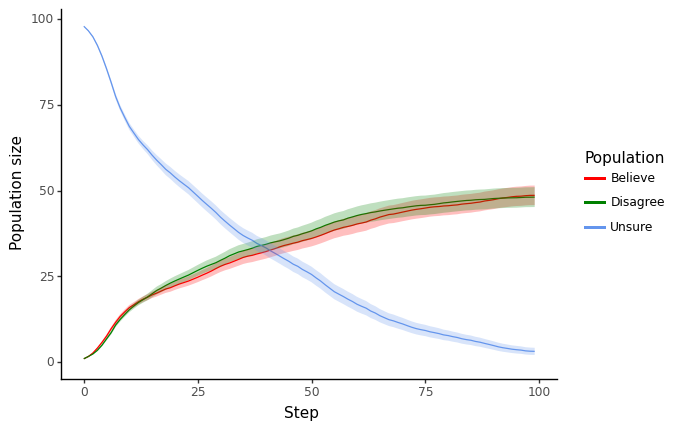

In [16]:
dynamics, network = ModelType.SIR, NetworkType.CAVEMAN 
run_trajectories(dynamics, network, n_replicates = 100)

### SIR with WINDMILL Network

In [ ]:
dynamics, network = ModelType.SIR, NetworkType.WINDMILL 
run_trajectories(dynamics, network, n_replicates = 100)


### SIR with SMALLWORLD Network 

Run: 100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


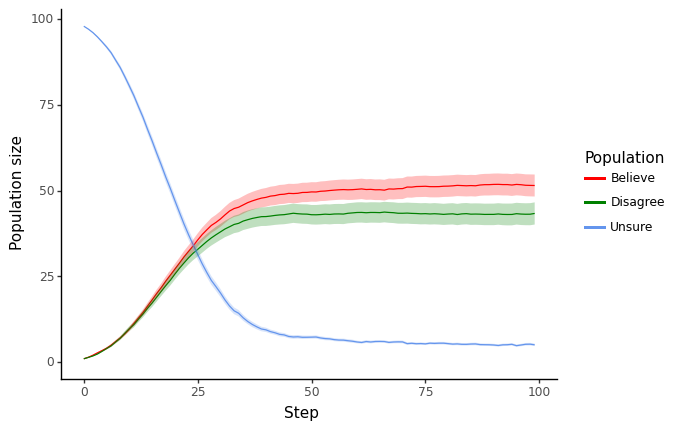

In [19]:
dynamics, network = ModelType.SIR, NetworkType.SMALLWORLD 
run_trajectories(dynamics, network, n_replicates = 100)


### SIR with BARABASI_ALBERT Network

Run: 100%|██████████| 100/100 [00:21<00:00,  4.73it/s]


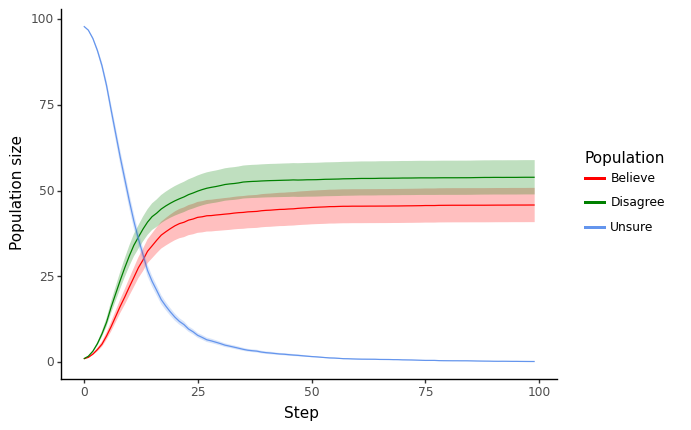

In [20]:
dynamics, network = ModelType.SIR, NetworkType.BARABASI_ALBERT 
run_trajectories(dynamics, network, n_replicates = 100)


## SEIZ Model

In [21]:
#number of steps for SEIZ trajectories
SEIZ_steps = 250

### SEIZ with CAVEMEN Network

Run: 100%|██████████| 100/100 [00:24<00:00,  4.09it/s]


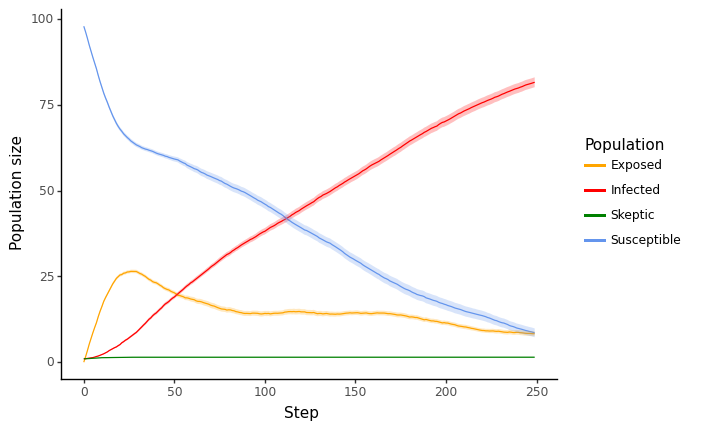

In [41]:
dynamics, network = ModelType.SEIZ, NetworkType.CAVEMAN
run_trajectories(dynamics, network, n_replicates = 100, n_steps = SEIZ_steps)

### SEIZ with WINDMILL Network

In [ ]:
dynamics, network = ModelType.SEIZ, NetworkType.WINDMILL 
run_trajectories(dynamics, network, n_replicates = 100, n_steps = SEIZ_steps)

### SEIZ with SMALLWORLD Network

Run: 100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


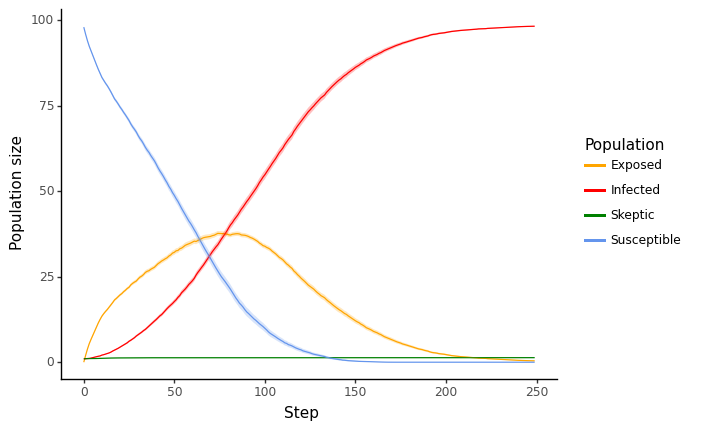

In [44]:
dynamics, network = ModelType.SEIZ, NetworkType.SMALLWORLD 
run_trajectories(dynamics, network, n_replicates = 100, n_steps = SEIZ_steps)

### SEIZ with BARABASI_ALBERT Network

Run: 100%|██████████| 100/100 [00:25<00:00,  3.87it/s]


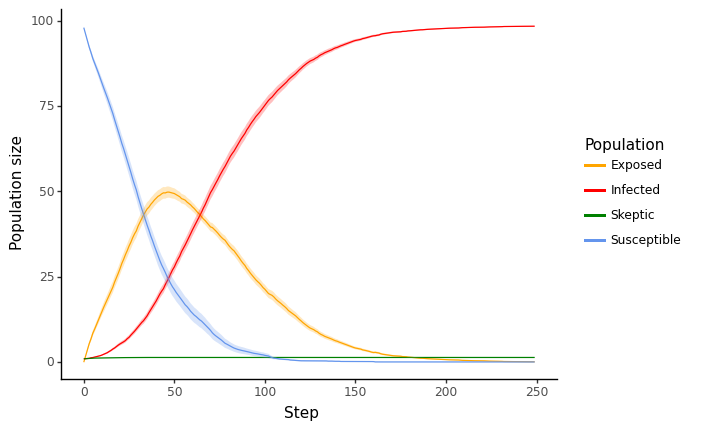

In [45]:
dynamics, network = ModelType.SEIZ, NetworkType.BARABASI_ALBERT 
run_trajectories(dynamics, network, n_replicates = 100, n_steps = SEIZ_steps)

## SEIZPlus Model

Run: 100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


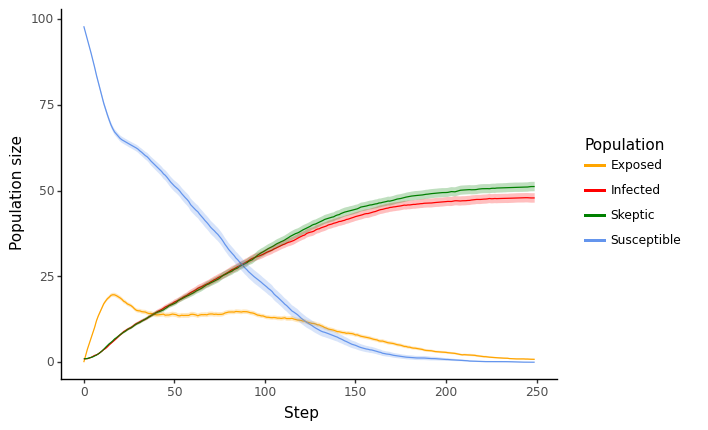

In [25]:
dynamics, network = ModelType.SEIZplus, NetworkType.CAVEMAN 
run_trajectories(dynamics, network, n_replicates = 100, n_steps = SEIZ_steps)

### SEIZPlus with WINDMILL Network

In [ ]:
dynamics, network = ModelType.SEIZplus, NetworkType.WINDMILL 
run_trajectories(dynamics, network, n_replicates = 100, n_steps = SEIZ_steps)

### SEIZPlus with SMALLWORLD Network

Run: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


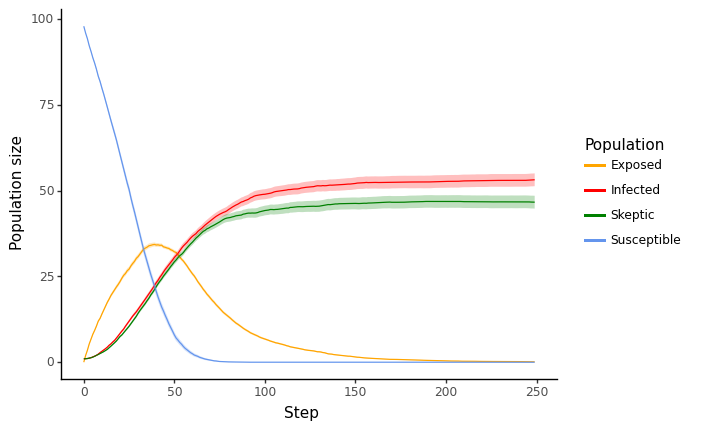

In [27]:
dynamics, network = ModelType.SEIZplus, NetworkType.SMALLWORLD 
run_trajectories(dynamics, network, n_replicates = 100, n_steps = SEIZ_steps)

### SEIZPlus with BARABASI Network

Run: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


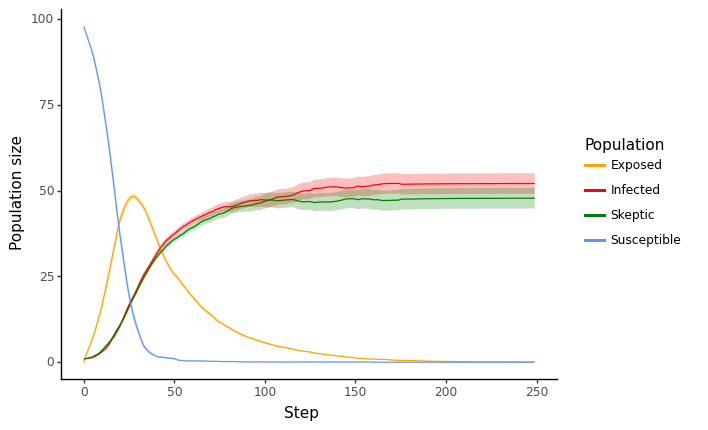

In [28]:
dynamics, network = ModelType.SEIZplus, NetworkType.BARABASI_ALBERT 
run_trajectories(dynamics, network, n_replicates = 100, n_steps = SEIZ_steps)

## SEIZM Model

## SEIZM with CAVEMAN Network

Run: 100%|██████████| 100/100 [00:53<00:00,  1.85it/s]


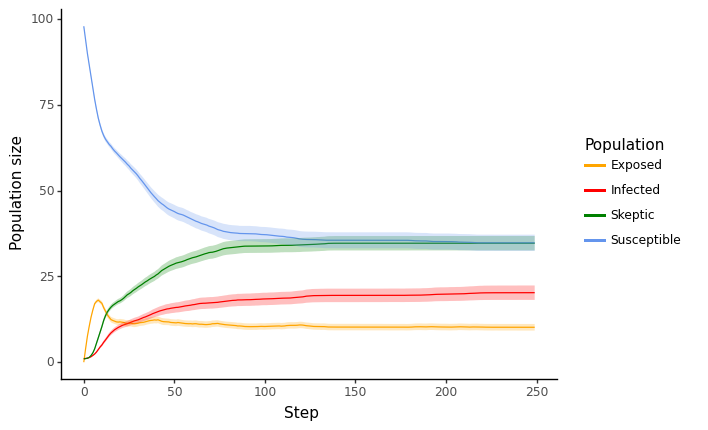

In [29]:
dynamics, network = ModelType.SEIZM, NetworkType.CAVEMAN
run_trajectories(dynamics, network, n_replicates = 100, n_steps = SEIZ_steps)

## SEIZM with WINDMILL Network

In [ ]:
dynamics, network = ModelType.SEIZM, NetworkType.WINDMILL
run_trajectories(dynamics, network, n_replicates = 100, n_steps = SEIZ_steps)

## SEIZM with SMALLWORLD Network

Run: 100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


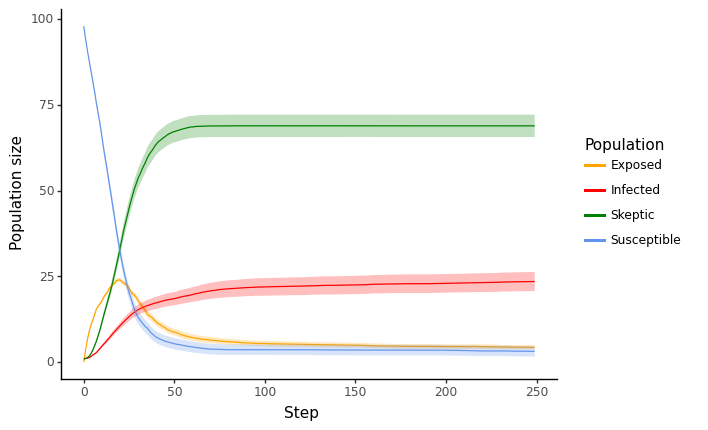

In [30]:
dynamics, network = ModelType.SEIZM, NetworkType.SMALLWORLD
run_trajectories(dynamics, network, n_replicates = 100, n_steps = SEIZ_steps)

## SEIZM with BARABASI_ALBERT Network

Run: 100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


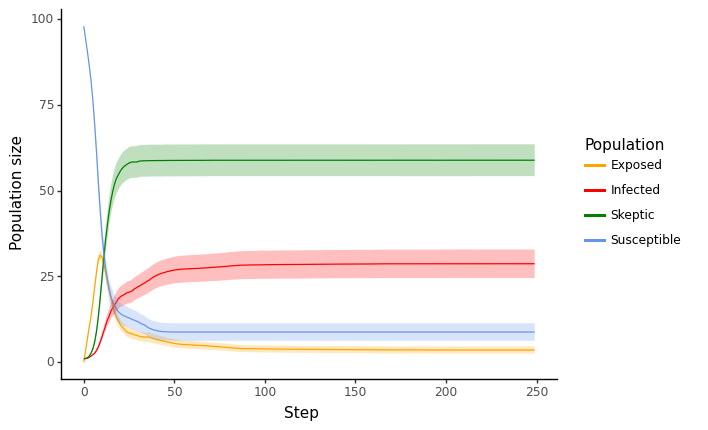

In [31]:
dynamics, network = ModelType.SEIZM, NetworkType.BARABASI_ALBERT
run_trajectories(dynamics, network, n_replicates = 100, n_steps = SEIZ_steps)